In [1]:
import pandas as pd
import numpy as np
import glob
import statsmodels
from statsmodels.stats import multicomp
from matplotlib_venn import *
from pylab import *
from collections import Counter
from matplotlib import rc
import seaborn as sns
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

Loading STR data

In [2]:
STRs = pd.read_table('../data/STRs_depth5_chr_start_maf09.annotated.tsv')
nvSTRs = pd.read_table('../data/STRs_depth5_chr_start_maf09_nv.annotated.tsv')

Loading lme results, from the R script bioclim_lme_mergedgroups.R, this is **Supplementary Data 1**

In [3]:
data = pd.read_csv('../data/lmeResDF_mergedgroups.csv')
control_data = pd.read_csv('../data/lmeResDF_mergedgroups_control.csv')

#  Giving STR loci in promoters the gene name in the 'Gene' column
promoter = data[data['WHERE']=='PROMOTER']
rest = data[data['WHERE']!='Promoter']
promoter['Gene'] = [x for x in promoter.Closest]
data = pd.concat([promoter, rest])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Function to correct for multiple testing

In [4]:
def correct(p_values):
    return statsmodels.sandbox.stats.multicomp.multipletests(p_values, alpha = 0.05, method = 'fdr_bh' )

Correcting for multiple testing

In [5]:
corrected_frame = data[correct(data.p_value)[0]]

This gene list is used in GeneMANIA (using Cytoscape)

In [6]:
for_geneMANIA = []
for i in set(corrected_frame[corrected_frame['WHERE']=='CDS'].Gene):
    for_geneMANIA.append(i.split('.')[0])

The histograms show P-value inflation in real STR data compared with control

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


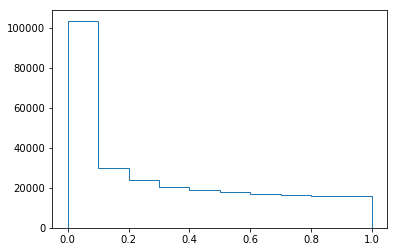

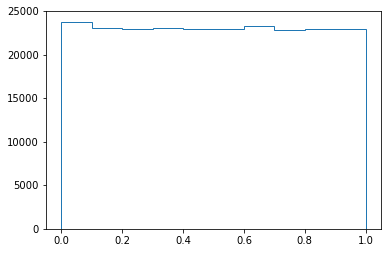

In [7]:
# Real STRs
hist(data.p_value, histtype = 'step')
show()

# Shuffled STRs
hist(control_data.p_value, histtype = 'step')
show()

Another way of showing this is with a Quantile-Quantile (QQ) plot

Function for making QQ plot

In [8]:
def plot_QQ(observed, control):
    o = observed
    c = control
    real_sort = sort(o.p_value)
    control_sort = sort(c.p_value)
    obs_x = [-log10(i) for i in sorted(linspace(0, 1, len(real_sort)))]
    obs_y = [-log10(i) for i in real_sort]
    control_x = [-log10(i) for i in sorted(linspace(0, 1, len(control_sort)))]
    control_y = [-log10(i) for i in control_sort]

    # Plotting 
    fig, ax = subplots(figsize = (4,3.5))
    ax.tick_params(direction='out', length=6, width=1, axis = 'both')
    
    scatter(obs_x, obs_y, color = 'Red', s = 3, label = 'Observed')
    scatter(control_x, control_y, color = 'Black', s = 3, alpha = 0.5, label = 'Shuffled control')
    plot([0,5],[0,5], color="gray", label = 'Expected')

    ax.legend(loc = 'upper left', fontsize = 13, markerscale = 2, frameon = True)

    xlim(0, 5)
    #ylim(0, 50)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticklabels(ax.get_xticks(), size=18)
    ax.set_yticklabels(ax.get_yticks(), size=18)

    tight_layout()
    savefig('../Figures/Env_QQ_plot.pdf', type = 'pdf', transparent = True)
    savefig('../Figures/Env_QQ_plot.png', type = 'png', dpi = 300, transparent = True)

    show()

### Figure 2.a

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


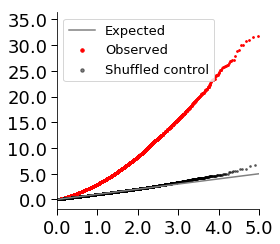

In [9]:
plot_QQ(data, control_data)

### S.Figure
Plotting for each environmental variable

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


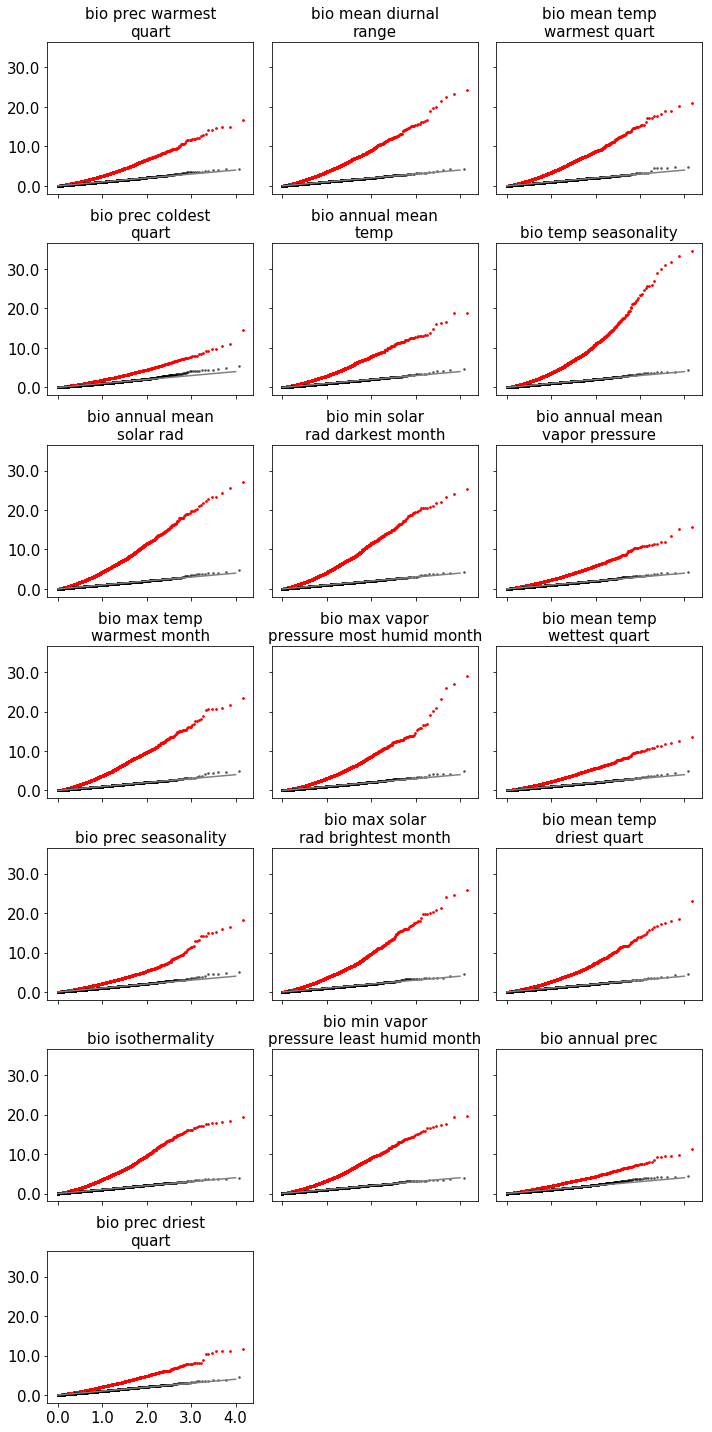

In [10]:
f, axes = subplots(ncols = 3, nrows = 7, sharey = True, sharex = True, figsize = (10,20), squeeze=False)
row = 0
col = -1
for variable in set(data.VARIABLE):
    col += 1
    if col > 2:
        row += 1
        col = 0
    c = control_data[control_data.VARIABLE == variable]
    o = data[data.VARIABLE == variable]
    
    control_sort = sort(c.p_value)
    real_sort = sort(o.p_value)
    curr_ax = axes[row][col]
    
    obs_x = [-log10(i) for i in sorted(linspace(0, 1, len(real_sort)))]
    obs_y = [-log10(i) for i in real_sort]
    control_x = [-log10(i) for i in sorted(linspace(0, 1, len(control_sort)))]
    control_y = [-log10(i) for i in control_sort]

    curr_ax.scatter(obs_x, obs_y, color = 'Red', s = 3)
    curr_ax.scatter(control_x, control_y, color = 'Black', s = 3, alpha = 0.5)
    curr_ax.plot([0,4],[0,4], color="gray")
    curr_ax.set_xticklabels(curr_ax.get_xticks(), size=15)
    curr_ax.set_yticklabels(curr_ax.get_yticks(), size=15)
    curr_ax.set_title(variable.lower().replace('_', ' ', 2).replace('_', '\n', 1).replace('_', ' '), size = 15)
    tight_layout()
f.delaxes(axes[-1][-1])
f.delaxes(axes[-1][-2])


savefig('../Figures/Env_QQplots_by_variable.pdf', kind = 'pdf', transparent = True)
savefig('../Figures/Env_QQplots_by_variable.png', kind = 'png', transparent = True, dpi = 300)


show()

### Figure 2.b - Boxplots, top 8 genic association

In [11]:
sub_strs = STRs[['ACCESSION', 'STR_DOSAGE', 'CHR_START', 'GENE']]

Filtering for genic STRs

In [12]:
cf_gene = corrected_frame[corrected_frame['WHERE'].isin(['PROMOTER', 'CDS', 'SPANNING', 'INTRON', 'FIVE_PRIME_UTR', 'THREE_PRIME_UTR'])]

Getting environmental data for each accession as harvested in R

In [13]:
BioClim = pd.read_csv('../data/allGenesAllAccBioClim.csv')

Columns with names of variables

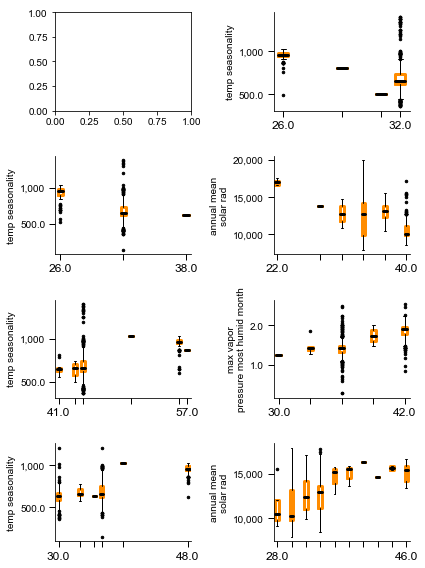

In [14]:
import seaborn as sns

f, axes = subplots(nrows = 4, ncols = 2, figsize=(6, 8))

counter = 0

for row in cf_gene.sort_values(by = 'p_value')[['CHR_START', 'Gene', 'Closest', 'p_value', 'VARIABLE']].drop_duplicates(subset = 'Gene').head(7).itertuples():
    counter += 1
    ax = axes.flatten()[counter]
    
    ax.tick_params(direction='out', length=6, width=1, axis = 'both')


    boxprops = dict(linestyle='-', linewidth=3, color='darkorange')
    flierprops = dict(marker='.', markerfacecolor='black', markersize=5, linestyle='none')
    medianprops = dict(linestyle='-', linewidth=3, color='black')

    variable = row.VARIABLE
    loci = row.CHR_START
    sns.set_style('white')
    d = pd.merge(sub_strs[sub_strs['CHR_START']==loci], BioClim)
    d = d[['ACCESSION', 'STR_DOSAGE', variable, 'CHR_START']].drop_duplicates()
    x = d.STR_DOSAGE
    y = d[variable]
    variants = []
    environment = []
    df = pd.DataFrame([y, x]).T
    for i in set(df['STR_DOSAGE']):
        variants.append(i)
        environment.append(list(df[df['STR_DOSAGE']==i][variable].values))
    

    
    ax.boxplot(environment, positions = variants, boxprops = boxprops, flierprops=flierprops,
               medianprops = medianprops)

    
    ticks = []
    for tick in ax.xaxis.get_ticklabels():
        ticks.append(tick.get_text())
    for tick in ax.xaxis.get_ticklabels():
        if tick.get_text() == min(ticks) or tick.get_text() == max(ticks):
            tick.set_fontsize(12)
        else:
            tick.set_visible(False)
    
    import matplotlib.ticker as tkr

    def func(x, pos):
        if x >= 1000:
            label = format(x, ',.0f')
        else:
            label = x
        return label
    y_format = tkr.FuncFormatter(func)  # make formatter
    ax.yaxis.set_major_formatter(y_format)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ylab = variable.lower().replace('_', ' ', 2).replace('_', '\n', 1).replace('_', ' ').replace('bio ', '')
    ax.yaxis.set_label_text(ylab)
tight_layout()
savefig('../Figures/Env_corr_top8.pdf', kind = 'pdf', transparent = True)
savefig('../Figures/Env_corr_top8.png', kind = 'png', transparent = True, dpi = 300)
show()

### Figure 2.c - GO term and KEGG pathway enrichment

The list of genes with STR loci with significant p-values after correcting for multiple testing was uploaded to Araport. Tables of enriched terms were copied and saved as a text file. As there are many very general and redundant terms for Biological Processes, we limited the number of genes within each term to be less than 500 and take the top 20 by p-value. The full list is in Supplementary Data.

In [15]:
araport = pd.read_table('../data/AraportGOenrichmentEnvsigMergedgroups.tsv', 
              header = None, names = ['none','GO', 'p', 'n'])[['GO', 'p', 'n']]
araport.GO = [i.split('[')[0] for i in araport.GO]
araport = araport[araport['n']<500].head(n = 20)
#araport.GO = ['BP: ' + i.split('[')[0] for i in araport.GO]

araportMF = pd.read_table('../data/AraportGOenrichmentEnvsigMergedgroupsMF.tsv', 
              header = None, names = ['none','GO', 'p', 'n'])[['GO', 'p', 'n']]
araportMF.GO = [i.split('[')[0] for i in araportMF.GO]
araportMF = araportMF[araportMF['GO'].isin(['DNA binding ',
                                'protein binding ', 'protein kinase activity '])]
#araportMF.GO = ['MF: ' + i.split('[')[0] for i in araportMF.GO]

araportpathway = pd.read_table('../data/AraportPathwayEnrichmentEnvsigMergedgroups.tsv', 
              header = None, names = ['none','GO', 'p', 'n'])[['GO', 'p', 'n']]
araportpathway.GO = [i.split('[')[0] for i in araportpathway.GO]

GO_all = pd.concat([araport, araportMF, araportpathway])


Making color palette

In [16]:
colors = []
takefrom = sns.color_palette('OrRd', 7)
for value in GO_all['p']:
    if value < 0.00005:
        colors.append(takefrom[6])
    elif value < 0.0001:
        colors.append(takefrom[5])
    elif value < 0.0005:
        colors.append(takefrom[4])
    elif value < 0.001:
        colors.append(takefrom[3])
    elif value < 0.005:
        colors.append(takefrom[2])
    elif value < 0.01:
        colors.append(takefrom[1])
    elif value < 0.05:
        colors.append(takefrom[0])

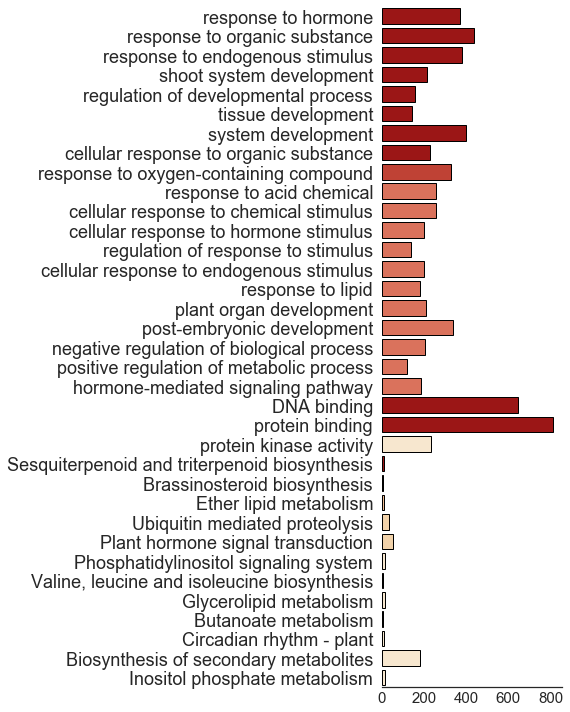

In [17]:
sns.set_style('white')
f, ax = subplots(figsize = (8, 10))
#pal = sns.color_palette("Oranges", len(GO_all.n))
rank = GO_all["p"].argsort()
ax = sns.barplot(y = "GO", x = 'n', data = GO_all, palette=colors,
                 linewidth = 1, edgecolor = 'Black')
ax.set_yticklabels(ax.get_yticklabels(), size=18)
xticks(size = 15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
xlabel('')
ylabel('')
tight_layout()
savefig('../Figures/AraportSigEnvMergedGroups_wMFandKEGG.pdf', bbox_inches = 'tight', type = 'pdf', transparent = True)
savefig('../Figures/AraportSigEnvMergedGroups_wMFandKEGG.png', type = 'png', transparent = True)


show()

Making legend

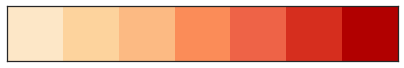

In [18]:
sns.palplot(takefrom, size = 1)

savefig('../Figures/AraportSigEnvMergedGroups_wMFandKEGG_legend.pdf', bbox_inches = 'tight', type = 'pdf', transparent = True)
savefig('../Figures/AraportSigEnvMergedGroups_wMFandKEGG_legend.png', type = 'png', transparent = True)
show()